In [1]:
import pickle
df = pickle.load(open("dataframe.pkl","rb"))

In [2]:
from elote import EloCompetitor
ratings = {}
for x in df.home_team_abbr.unique():
    ratings[x]=EloCompetitor()
for x in df.away_team_abbr.unique():
    ratings[x]=EloCompetitor()

home_team_elo = []
away_team_elo = []
elo_exp = []

df = df.sort_values(by='date').reset_index(drop=True)
for i, r in df.iterrows():
    # get pre-game ratings
    elo_exp.append(ratings[r.home_team_abbr].expected_score(ratings[r.away_team_abbr]))
    home_team_elo.append(ratings[r.home_team_abbr].rating)
    away_team_elo.append(ratings[r.away_team_abbr].rating)
    # update ratings
    if r.home_team_win:
        ratings[r.home_team_abbr].beat(ratings[r.away_team_abbr])
    else:
        ratings[r.away_team_abbr].beat(ratings[r.home_team_abbr])

df['elo_exp'] = elo_exp
df['home_team_elo'] = home_team_elo
df['away_team_elo'] = away_team_elo

In [3]:
ratings = {}
for x in df.home_team_abbr.unique():
    ratings[x]=EloCompetitor()
    ratings[x]._k_score=16
for x in df.away_team_abbr.unique():
    ratings[x]=EloCompetitor()
    ratings[x]._k_score=16

home_team_elo = []
away_team_elo = []
elo_exp = []

df = df.sort_values(by='date').reset_index(drop=True)
for i, r in df.iterrows():
    # get pregame ratings
    elo_exp.append(ratings[r.home_team_abbr].expected_score(ratings[r.away_team_abbr]))
    home_team_elo.append(ratings[r.home_team_abbr].rating)
    away_team_elo.append(ratings[r.away_team_abbr].rating)
    # update ratings
    if r.home_team_win:
        ratings[r.home_team_abbr].beat(ratings[r.away_team_abbr])
    else:
        ratings[r.away_team_abbr].beat(ratings[r.home_team_abbr])

df['elo_slow_exp'] = elo_exp
df['home_team_elo_slow'] = home_team_elo
df['away_team_elo_slow'] = away_team_elo

In [4]:
from elote import GlickoCompetitor
ratings = {}
for x in df.home_team_abbr.unique():
    ratings[x]=GlickoCompetitor()
for x in df.away_team_abbr.unique():
    ratings[x]=GlickoCompetitor()

home_team_glick = []
away_team_glick = []
glick_exp = []

df = df.sort_values(by='date').reset_index(drop=True)
for i, r in df.iterrows():
    # get pregame ratings
    glick_exp.append(ratings[r.home_team_abbr].expected_score(ratings[r.away_team_abbr]))
    home_team_glick.append(ratings[r.home_team_abbr].rating)
    away_team_glick.append(ratings[r.away_team_abbr].rating)
    # update ratings
    if r.home_team_win:
        ratings[r.home_team_abbr].beat(ratings[r.away_team_abbr])
    else:
        ratings[r.away_team_abbr].beat(ratings[r.home_team_abbr])

df['glick_exp'] = glick_exp
df['home_team_glick'] = home_team_glick
df['away_team_glick'] = away_team_glick

In [5]:
from trueskill import Rating, quality, rate
ratings = {}
for x in df.home_team_abbr.unique():
    ratings[x]=Rating(25)
for x in df.away_team_abbr.unique():
    ratings[x]=Rating(25)
for x in df.home_pitcher.unique():
    ratings[x]=Rating(25)
for x in df.away_pitcher.unique():
    ratings[x]=Rating(25)

ts_quality = []
pitcher_ts_diff = []
team_ts_diff = []
home_pitcher_ts = []
away_pitcher_ts = []
home_team_ts = []
away_team_ts = []
df = df.sort_values(by='date').copy()
for i, r in df.iterrows():
    # get pre-match trueskill ratings from dict
    match = [(ratings[r.home_team_abbr], ratings[r.home_pitcher]),
            (ratings[r.away_team_abbr], ratings[r.away_pitcher])]
    ts_quality.append(quality(match))
    pitcher_ts_diff.append(ratings[r.home_pitcher].mu-ratings[r.away_pitcher].mu)
    team_ts_diff.append(ratings[r.home_team_abbr].mu-ratings[r.away_team_abbr].mu)
    home_pitcher_ts.append(ratings[r.home_pitcher].mu)
    away_pitcher_ts.append(ratings[r.away_pitcher].mu)
    home_team_ts.append(ratings[r.home_team_abbr].mu)
    away_team_ts.append(ratings[r.away_team_abbr].mu)

    if r.date < df.date.max():
        # update ratings dictionary with post-match ratings
        if r.home_team_win==1:
            match = [(ratings[r.home_team_abbr], ratings[r.home_pitcher]),
                     (ratings[r.away_team_abbr], ratings[r.away_pitcher])]
            [(ratings[r.home_team_abbr], ratings[r.home_pitcher]),
            (ratings[r.away_team_abbr], ratings[r.away_pitcher])] = rate(match)
        else:
            match = [(ratings[r.away_team_abbr], ratings[r.away_pitcher]),
                     (ratings[r.home_team_abbr], ratings[r.home_pitcher])]
            [(ratings[r.away_team_abbr], ratings[r.away_pitcher]),
            (ratings[r.home_team_abbr], ratings[r.home_pitcher])] = rate(match)

df['ts_game_quality'] = ts_quality
df['pitcher_ts_diff'] = pitcher_ts_diff
df['team_ts_diff'] = team_ts_diff
df['home_pitcher_ts'] = home_pitcher_ts
df['away_pitcher_ts'] = away_pitcher_ts
df['home_team_ts'] = home_team_ts
df['away_team_ts'] = away_team_ts

In [6]:
import pandas as pd
dates = pd.to_datetime(df['date'], unit='s')
game_days = dates.dt.strftime('%Y-%m-%d').unique()
print("Days of odds data needed:", len(game_days))

Days of odds data needed: 913


In [7]:
import requests
from bs4 import BeautifulSoup as bs
import datetime as dt

game_data = []
for d in game_days:
    # get the web page with game data on it
    url = f'https://www.covers.com/Sports/MLB/Matchups?selectedDate={d}'
    resp = requests.get(url)

    # parse the games
    scraped_games = bs(resp.text).findAll('div',{'class':'cmg_matchup_game_box'})
    for g in scraped_games:
        game = {}
        game['home_moneyline'] = g['data-game-odd']
        game['date'] = g['data-game-date']
        game['away_team_abbr'] = g['data-away-team-shortname-search']
        game['home_team_abbr'] = g['data-home-team-shortname-search']
        try:
            game['home_score'] =g.find('div',{'class':'cmg_matchup_list_score_home'}).text.strip()
            game['away_score'] =g.find('div',{'class':'cmg_matchup_list_score_away'}).text.strip()
        except:
            game['home_score'] =''
            game['away_score'] =''

        game_data.append(game)
        if len(game_data) % 1000==0:
            #show progress
            print(dt.datetime.now(), d, len(game_data))
print("Done! Games downloaded:", len(game_data))

2021-07-10 04:16:34.611111 2016-06-15 1000
2021-07-10 04:17:14.204255 2016-08-31 2000
2021-07-10 04:18:00.489954 2017-05-10 3000
2021-07-10 04:18:36.691090 2017-07-24 4000
2021-07-10 04:19:22.889206 2018-03-29 5000
2021-07-10 04:20:03.237488 2018-06-10 6000
2021-07-10 04:20:40.795074 2018-08-26 7000
2021-07-10 04:21:28.050338 2019-05-01 8000
2021-07-10 04:22:10.499473 2019-07-17 9000
2021-07-10 04:22:48.600502 2019-09-29 10000
2021-07-10 04:23:35.325977 2020-09-26 11000
Done! Games downloaded: 11071


In [8]:
import pickle
pickle.dump(game_data, open('covers_data_2.pkl','wb'))

In [9]:
import pickle
game_data = pickle.load(open('covers_data_2.pkl','rb'))

In [10]:
import numpy as np
import pandas as pd
odds = pd.DataFrame(game_data)
odds['home_moneyline'].replace('', np.nan, inplace=True)
odds.dropna(subset=['home_moneyline'], inplace=True)
odds.home_moneyline = pd.to_numeric(odds.home_moneyline)
odds.date = pd.to_datetime(odds.date).dt.date

In [11]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

odds.home_team_abbr[odds.home_team_abbr=='SF']='SFG'
odds.home_team_abbr[odds.home_team_abbr=='TB']='TBR'
odds.home_team_abbr[odds.home_team_abbr=='WAS']='WSN'
odds.home_team_abbr[odds.home_team_abbr=='KC']='KCR'
odds.home_team_abbr[odds.home_team_abbr=='SD']='SDP'

odds.away_team_abbr[odds.away_team_abbr=='SF']='SFG'
odds.away_team_abbr[odds.away_team_abbr=='TB']='TBR'
odds.away_team_abbr[odds.away_team_abbr=='WAS']='WSN'
odds.away_team_abbr[odds.away_team_abbr=='KC']='KCR'
odds.away_team_abbr[odds.away_team_abbr=='SD']='SDP'

In [12]:
odds['odds_proba']=np.nan
odds['odds_proba'][odds.home_moneyline<0] = -odds.home_moneyline/(-odds.home_moneyline + 100)
odds['odds_proba'][odds.home_moneyline>0] = (100/(odds.home_moneyline + 100))

In [13]:
print('dataframe shape before merge:', df.shape)
# get dates into the same format
odds['date'] = (pd.to_datetime(pd.to_datetime(odds['date'])) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# do the merge
df = pd.merge_asof(left=df.sort_values(by='date'),
                   right=odds[['home_team_abbr','date', 'away_team_abbr','odds_proba']].sort_values(by='date'),
                   by=['home_team_abbr','away_team_abbr'],
                   on='date')
df = df.sort_values(by='date').copy().reset_index(drop=True)
print('dataframe shape after merge:', df.shape)

dataframe shape before merge: (10785, 1142)
dataframe shape after merge: (10785, 1143)


In [14]:
import pickle
pickle.dump(df, open('dataframe_part3.pkl','wb'))

In [15]:

import pickle
df = pickle.load(open('dataframe_part3.pkl','rb'))

In [16]:
import xgboost as xgb

# target encoding
encode_me = [x for x in df.keys() if 'object' in str(df[x].dtype)]
for x in encode_me:
    df[x] = df.groupby(x)['home_team_win'].apply(lambda x:x.rolling(180).mean()).shift(1)

# create test, train splits
df = df.sort_values(by='date').copy().reset_index(drop=True)
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win

X_train = X[:-1000]
y_train = y[:-1000]
X_valid = X[-1000:-500]
y_valid = y[-1000:-500]
X_test = X[-500:]
y_test = y[-500:]

In [17]:
params = {'learning_rate': 0.035,'max_depth': 1}
gbm = xgb.XGBClassifier(**params)
model = gbm.fit(X_train, y_train,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                eval_metric='logloss',
                early_stopping_rounds=10)
xgb_test_preds = model.predict(X_test)
xgb_test_proba = model.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.69208	validation_1-logloss:0.69195
[1]	validation_0-logloss:0.69108	validation_1-logloss:0.69072
[2]	validation_0-logloss:0.69015	validation_1-logloss:0.68981
[3]	validation_0-logloss:0.68927	validation_1-logloss:0.68872
[4]	validation_0-logloss:0.68844	validation_1-logloss:0.68787
[5]	validation_0-logloss:0.68766	validation_1-logloss:0.68710
[6]	validation_0-logloss:0.68691	validation_1-logloss:0.68624
[7]	validation_0-logloss:0.68620	validation_1-logloss:0.68555
[8]	validation_0-logloss:0.68554	validation_1-logloss:0.68487
[9]	validation_0-logloss:0.68491	validation_1-logloss:0.68426
[10]	validation_0-logloss:0.68431	validation_1-logloss:0.68366
[11]	validation_0-logloss:0.68374	validation_1-logloss:0.68324
[12]	validation_0-logloss:0.68319	validation_1-logloss:0.68260
[13]	validation_0-logloss:0.68267	validation_1-logloss:0.68227
[14]	validation_0-logloss:0.68216	validation_1-logloss:0.68176
[15]	validation_0-logloss:0.68169	validation_1-logloss:0.68151
[1

Casino		Accuracy:0.5860	 Brier Loss: 0.2396
XGBoost		Accuracy:0.5840	 Brier Loss: 0.2406


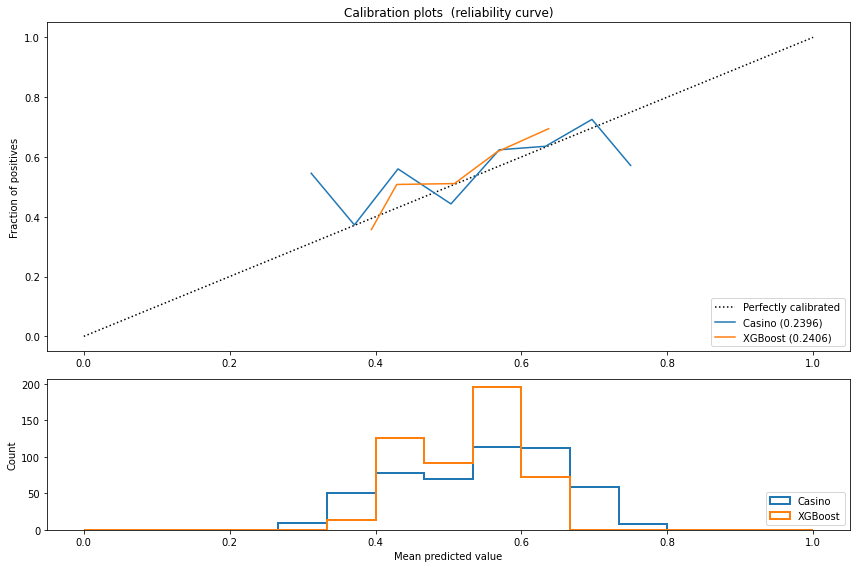

In [18]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt
import pickle

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_pred, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\t\tAccuracy:{:.4f}\t Brier Loss: {:.4f}".format(
            name, accuracy_score(y_test, y_pred), brier))
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

casino_proba = X_test['odds_proba']
casino_preds = X_test['odds_proba']>.5

data = [
    (y_test, casino_preds, casino_proba, 'Casino'),
    (y_test,xgb_test_preds, xgb_test_proba, 'XGBoost')
]
cal_curve(data, 15)